#  Non-Linear Modeling



In this lab, we demonstrate some of the nonlinear models discussed in
this chapter. We use the `Wage`  data as a running example, and show that many of the complex non-linear fitting procedures discussed can easily be implemented in \Python.

As usual, we start with some of our standard imports.

In [34]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings('ignore')

We again collect the new imports
needed for this lab. Many of these are developed specifically for the
`ISLP` package.

In [2]:
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

## Polynomial Regression and Step Functions
We start by demonstrating how Figure 7.1 can be reproduced.
Let's  begin by loading the data.

In [3]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

In [4]:
Wage.head(3)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


Throughout most of this lab, our response is `Wage['wage']`, which
we have stored as `y` above. 
As in Section 3.6.6, we will use the `poly()` function to create a model matrix
that will fit a $4$th degree polynomial in `age`.

In [5]:
poly_age = MS([poly('age', degree=4,raw=True)]).fit(Wage)
M = sm.GLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,-184.154200,60.040000,-3.067,0.002
"poly(age, degree=4, raw=True)[0]",21.245500,5.887000,3.609,0.000
"poly(age, degree=4, raw=True)[1]",-0.563900,0.206000,-2.736,0.006
"poly(age, degree=4, raw=True)[2]",0.006800,0.003000,2.221,0.026
"poly(age, degree=4, raw=True)[3]",-0.000032,0.000016,-1.952,0.051


This polynomial is constructed using the function `poly()`,
which creates
a special *transformer* `Poly()` (using `sklearn` terminology
for feature transformations) which
allows for easy evaluation of the polynomial at new data points. Here `poly()` is referred to as a *helper* function, and sets up the transformation; `Poly()` is the actual workhorse that computes the transformation. See also 
the 
discussion of transformations on
page 127. 

In the code above, the first line executes the `fit()` method
using the dataframe
`Wage`. This recomputes and stores as attributes any parameters needed by `Poly()`
on the training data, and these will be used on all subsequent
evaluations of the `transform()` method. For example, it is used
on the second line, as well as in the plotting function developed below.

We now create a grid of values for `age` at which we want
predictions.

In [6]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
age_df = pd.DataFrame({'age': age_grid})

Finally, we wish to plot the data and add the fit from the fourth-degree polynomial. As we will make
several similar plots below, we first write a function
to create all the ingredients and produce the plot.  Our function
takes in a model specification (here a basis specified by a
transform), as well as a grid of `age` values. The function
produces a fitted curve as well as 95% confidence bands. By using
an argument for `basis` we can produce and plot the results with several different
transforms, such as the splines we will see shortly.

In [7]:
def plot_wage_fit(age_df, 
                  basis,
                  title):

    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age,
               y,
               facecolor='gray',
               alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
    return ax

We include an argument `alpha` to `ax.scatter()`
to add some transparency to the points. This provides a visual indication
of density. Notice the use of the `zip()` function in the
`for` loop above (see Section 2.3.8).
We have three lines to plot, each with different colors and line
types. Here `zip()` conveniently bundles these together as
iterators in the loop. {In `Python`  speak, an "iterator" is an object with a finite number of values, that can be iterated on, as in a loop.}

We now plot the fit of the fourth-degree polynomial using this
function.

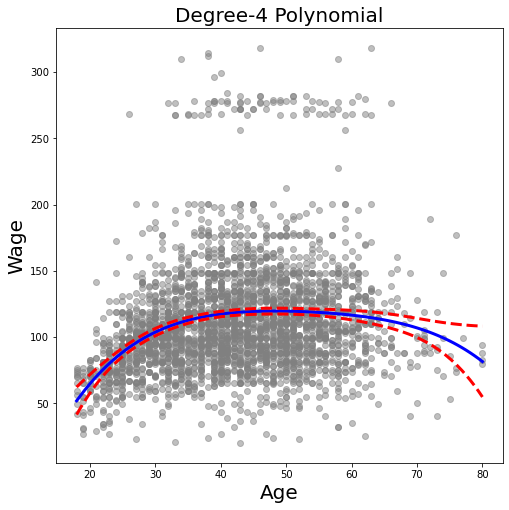

In [8]:
plot_wage_fit(age_df, 
              poly_age,
              'Degree-4 Polynomial');

We then fit logistic regression using polynomials.

In [9]:
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250 # shorthand
glm = sm.GLM(y > 250,
             X,
             family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-109.553000,47.65500,-2.299,0.022
"poly(age, degree=4, raw=True)[0]",8.995000,4.18700,2.148,0.032
"poly(age, degree=4, raw=True)[1]",-0.281600,0.13500,-2.081,0.037
"poly(age, degree=4, raw=True)[2]",0.003900,0.00200,2.022,0.043
"poly(age, degree=4, raw=True)[3]",-0.000019,0.00001,-1.966,0.049


Once again, we make predictions using the `get_prediction()`  method.

In [10]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

We now plot the estimated relationship.

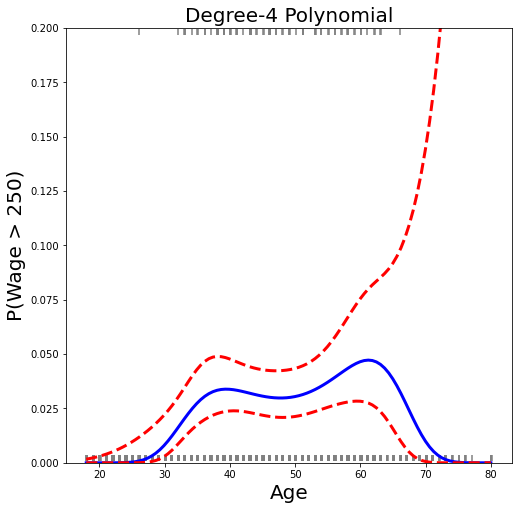

In [11]:
fig, ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age +
           0.2 * rng.uniform(size=y.shape[0]),
           np.where(high_earn, 0.198, 0.002),
           fc='gray',
           marker='|')
for val, ls in zip([preds.predicted_mean,
                  bands[:,0],
                  bands[:,1]],
                 ['b','r--','r--']):
    ax.plot(age_df.values, val, ls, linewidth=3)
ax.set_title('Degree-4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim([0,0.2])
ax.set_ylabel('P(Wage > 250)', fontsize=20);

We have drawn the `age` values corresponding to the observations with
`wage` values above 250 as gray marks on the top of the plot, and
those with `wage` values below 250 are shown as gray marks on the
bottom of the plot. We added a small amount of noise to jitter
the `age` values a bit so that observations with the same `age`
value do not cover each other up. This type of plot is often called a
*rug plot*.

In order to fit a step function, as discussed in
Section 7.2,   we first use the `pd.qcut()`
function to discretize `age` based on quantiles.  Then  we use `pd.get_dummies()` to create the
columns of the model matrix for this categorical variable. Note that this function will
include *all* columns for a given categorical, rather than the usual approach which drops one
of the levels.

In [12]:
cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


Here `pd.qcut()`  automatically picked the cutpoints based on the quantiles 25%, 50% and 75%, which results in four regions.  We could also have specified our own
quantiles directly instead of the argument `4`. For cuts not based
on quantiles we would use the `pd.cut()` function.
The function `pd.qcut()` (and `pd.cut()`) returns an ordered categorical variable.
  The regression model then creates a set of
dummy variables for use in the regression. Since `age` is the only variable in the model, the value $94,158.40 is the average salary for those under 33.75 years of
age, and the other coefficients are the average
salary for those in the other age groups.  We can produce
predictions and plots just as we did in the case of the polynomial
fit.

## Splines
In order to fit regression splines, we use transforms
from the `ISLP` package. The actual spline
evaluation functions are in the `scipy.interpolate` package;
we have simply wrapped them as transforms
similar to `Poly()` and `PCA()`.

In Section 7.4, we saw
that regression splines can be fit by constructing an appropriate
matrix of basis functions.  The `BSpline()`  function generates the
entire matrix of basis functions for splines with the specified set of
knots. By default, the B-splines produced are cubic. To change the degree, use
the argument `degree`.

In [13]:
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

This results in a seven-column matrix, which is what is expected for a cubic-spline basis with 3 interior knots. 
We can form this same matrix using the `bs()` object,
which facilitates adding this to a model-matrix builder (as in `poly()` versus its workhorse `Poly()`) described in Section 7.8.1.

We now fit a cubic spline model to the `Wage`  data.

In [14]:
bs_age = MS([bs('age', internal_knots=[25,40,60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


The column names are a little cumbersome, and have caused us to truncate the printed summary. They can be set on construction using the `name` argument as follows.

In [15]:
bs_age = MS([bs('age',
                internal_knots=[25,40,60],
                name='bs(age)')])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


Notice that there are 6 spline coefficients rather than 7. This is because, by default,
`bs()` assumes `intercept=False`, since we typically have an overall intercept in the model.
So it generates the spline basis with the given knots,  and then discards one of the basis functions to account for the intercept. 

We could also use the `df` (degrees of freedom) option to
specify the complexity of the spline.  We see above that with 3 knots,
the spline basis has 6 columns or degrees of freedom.  When we specify
`df=6` rather than the actual knots, `bs()` will produce a
spline with 3 knots chosen at uniform quantiles of the training data.
We can see these chosen knots most easily using `Bspline()` directly:

In [16]:
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

 When asking for six degrees of freedom,
the transform chooses knots at ages 33.75, 42.0, and 51.0,
which correspond to the 25th, 50th, and 75th percentiles of
`age`.

When using B-splines we need not limit ourselves to cubic polynomials
(i.e. `degree=3`). For instance, using `degree=0` results
in piecewise constant functions, as in our example with
`pd.qcut()` above.

In [17]:
bs_age0 = MS([bs('age',
                 df=3, 
                 degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


## Natural Spline
In order to fit a natural spline, we use the `NaturalSpline()` 
transform with the corresponding helper `ns()`.  Here we fit a natural spline with five
degrees of freedom (excluding the intercept) and plot the results.

In [18]:
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


We now plot the natural spline using our plotting function.

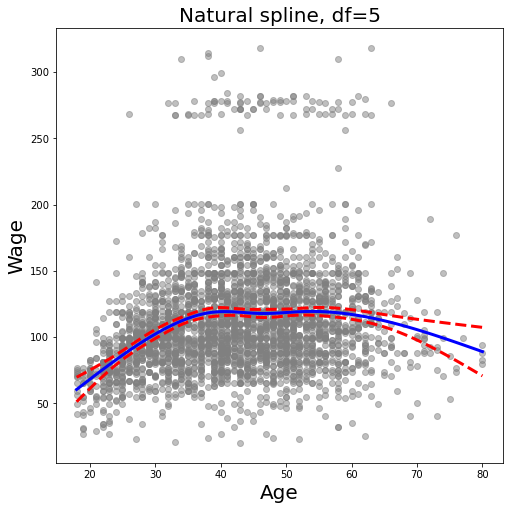

In [19]:
plot_wage_fit(age_df,
              ns_age,
              'Natural spline, df=5');

## Smoothing Splines and GAMs
A smoothing spline is a special case of a GAM with squared-error loss
and a single feature. To fit GAMs in `Python` we will use the
`pygam` package which can be installed via `pip install pygam`. The
estimator `LinearGAM()` uses squared-error loss.
The GAM is specified by associating each column
of a model matrix with a particular smoothing operation:
`s` for smoothing spline; `l` for linear, and `f` for factor or categorical variables.
The argument `0` passed to `s` below indicates that this smoother will
apply to the first column of a feature matrix. Below, we pass it a
matrix with a single column: `X_age`. The argument `lam` is the penalty parameter $\lambda$ as discussed in Section 7.5.2.

In [20]:
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

The `pygam` library generally expects a matrix of features so we reshape `age` to be a matrix (a two-dimensional array) instead
of a vector (i.e. a one-dimensional array). The `-1` in the call to the `reshape()` method tells `numpy` to impute the
size of that dimension based on the remaining entries of the shape tuple.
 
Let’s investigate how the fit changes with the smoothing parameter `lam`.
The function `np.logspace()` is similar to `np.linspace()` but spaces points
evenly on the log-scale. Below we vary `lam` from $10^{-2}$ to $10^6$.

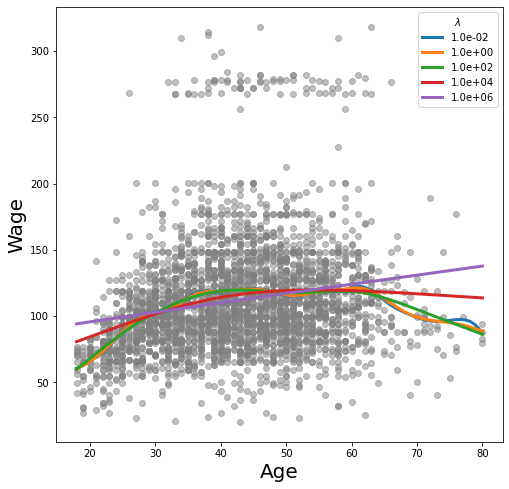

In [21]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:.1e}'.format(lam),
            linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='$\lambda$');

The `pygam` package can perform a search for an optimal smoothing parameter.

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


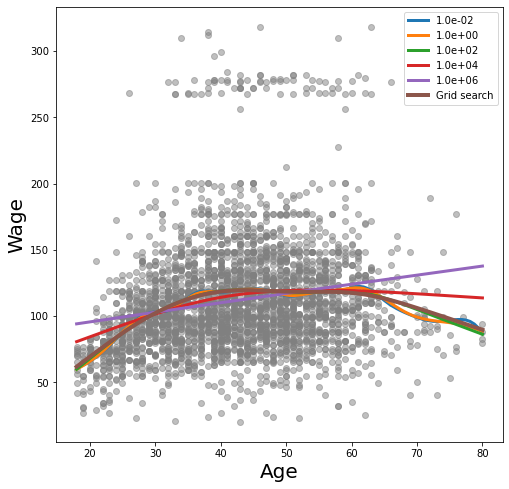

In [22]:
gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid,
        gam_opt.predict(age_grid),
        label='Grid search',
        linewidth=4)
ax.legend()
fig

Alternatively, we can fix the degrees of freedom of the smoothing
spline using a function included in the `ISLP.pygam` package. Below we
find a value of $\lambda$ that gives us roughly four degrees of
freedom. We note here that these degrees of freedom include the
unpenalized intercept and linear term of the smoothing spline, hence there are at least two
degrees of freedom.

In [23]:
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4


Let’s vary the degrees of freedom in a similar plot to above. We choose the degrees of freedom
as the desired degrees of freedom plus one to account for the fact that these smoothing
splines always have an intercept term. Hence, a value of one for `df` is just a linear fit.

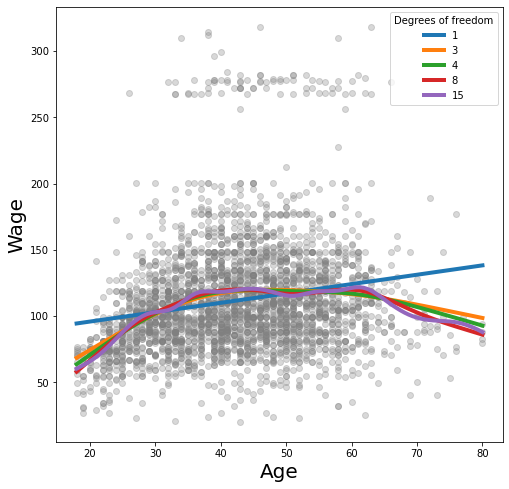

In [24]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(X_age,
           y,
           facecolor='gray',
           alpha=0.3)
for df in [1,3,4,8,15]:
    lam = approx_lam(X_age, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:d}'.format(df),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='Degrees of freedom');

### Additive Models with Several Terms
The strength of generalized additive models lies in their ability to fit multivariate regression models with more flexibility than linear models. We demonstrate two approaches: the first in a more manual fashion using natural splines and piecewise constant functions, and the second  using the `pygam` package and smoothing splines.

We now fit a GAM by hand to predict
`wage` using natural spline functions of `year` and `age`,
treating `education` as a qualitative predictor, as in (7.16).
Since this is just a big linear regression model
using an appropriate choice of basis functions, we can simply do this
using the `sm.OLS()`  function.

We will build the model matrix in a more manual fashion here, since we wish
to access the pieces separately when constructing partial dependence plots.

In [25]:
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),
      ns_year.transform(Wage['year']),
      pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

Here the function `NaturalSpline()` is the workhorse supporting
the `ns()` helper function.  We chose to use all columns of the
indicator matrix for the categorical variable `education`, making an intercept redundant.
Finally, we stacked the three component matrices horizontally to form the model matrix `X_bh`. 

We now show how to construct partial dependence plots for each of the terms in our rudimentary GAM. We can do this by hand,
given grids for `age` and `year`.
 We simply predict with new $X$ matrices, fixing all but one of the features at a time.

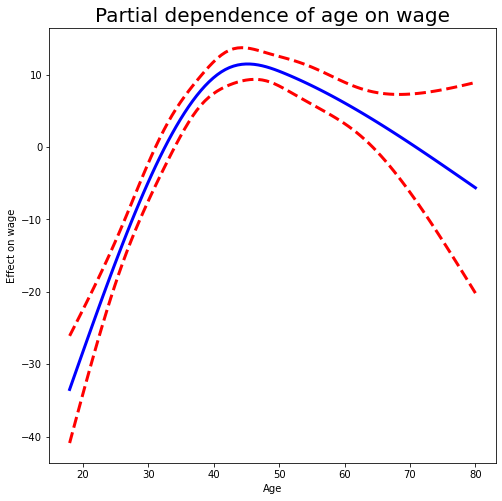

In [26]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20);

Let's explain in some detail what we did above. The idea is to create a new prediction matrix, where all but the columns belonging to `age` are constant (and set to  their training-data means). The four columns for `age` are filled in with the natural spline basis evaluated at the 100 values in `age_grid`.

* We made a grid of length 100 in `age`, and created a matrix `X_age_bh` with 100 rows and the same number of columns as `X_bh`.
* We replaced every row of this matrix with the column means of the original.
* We then replace just the first four columns representing `age` with the natural spline basis computed at the values in `age_grid`. 

The remaining steps should by now be familiar.

We also look at the effect of `year` on `wage`; the process is the same.

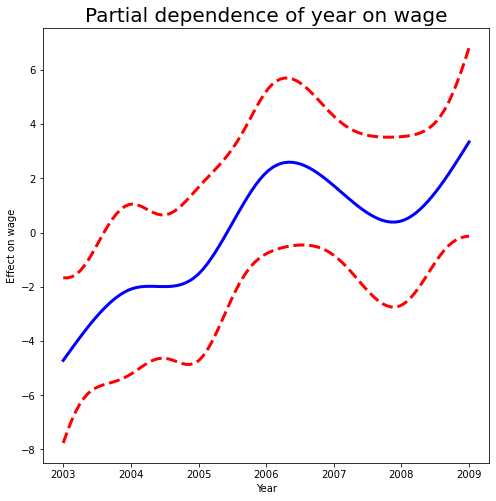

In [27]:
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(),
                        Wage['year'].max(),
                        100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(year_grid, partial_year, 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20);

We now fit the model (7.16)  using smoothing splines rather
than natural splines.  All of the
terms in  (7.16)  are fit simultaneously, taking each other
into account to explain the response. The `pygam` package only works with matrices, so we must convert
the categorical series `education` to its array representation, which can be found
with the `cat.codes` attribute of `education`. As `year` only has 7 unique values, we
use only seven basis functions for it.

In [28]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0))
Xgam = np.column_stack([age,
                        Wage['year'],
                        Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

The two `s_gam()` terms result in smoothing spline fits, and use a default value for $\lambda$  (`lam=0.6`), which is somewhat arbitrary. For the categorical term `education`, specified using a `f_gam()` term,  we specify `lam=0` to avoid any shrinkage.
We produce the partial dependence plot in `age` to see the effect of these choices.

The values for the plot
are generated by the `pygam` package. We provide a `plot_gam()`
function for partial-dependence plots in `ISLP.pygam`, which makes this job easier than in our last example with natural splines.

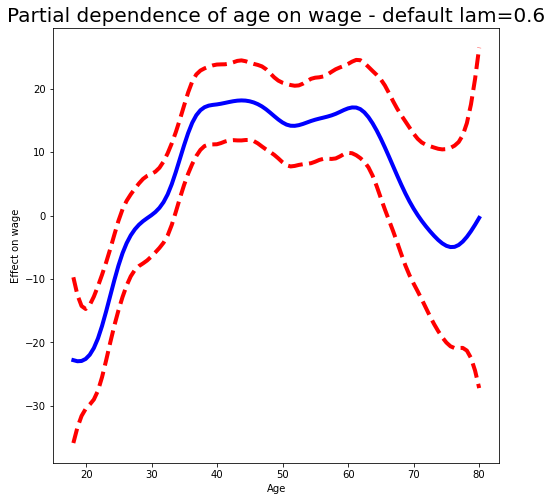

In [29]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=20);

We see that the function is somewhat wiggly. It is more natural to specify the `df` than a value for `lam`. 
We refit a GAM using four degrees of freedom each for
`age` and  `year`. Recall that the addition of one below takes into account the intercept
of the smoothing spline.

In [30]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

Note that updating `age_term.lam` above updates it in `gam_full.terms[0]` as well! Likewise for `year_term.lam`.

Repeating the plot for `age`, we see that it is much smoother.
We also produce the plot for `year`.

Text(0.5, 1.0, 'Partial dependence of year on wage')

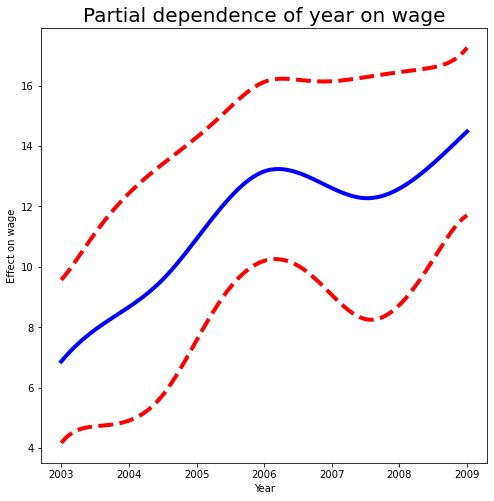

In [31]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full,
         1,
         ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)

Finally we plot `education`, which is categorical. The partial dependence plot is different, and more suitable for the set of fitted constants for each level of this variable.

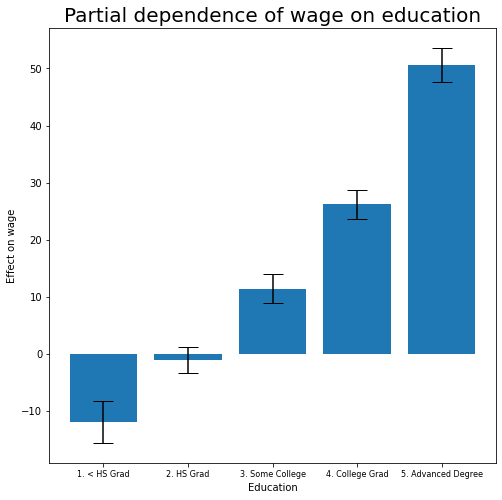

In [32]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);

## Local Regression
We illustrate the use of local regression using  the `lowess()` 
function from `sm.nonparametric`. Some implementations of
GAMs allow terms to be local regression operators; this is not the case in `pygam`.

Here we fit local linear regression models using spans of 0.2
and 0.5; that is, each neighborhood consists of 20% or 50% of
the observations. As expected, using a span of 0.5 is smoother than 0.2.

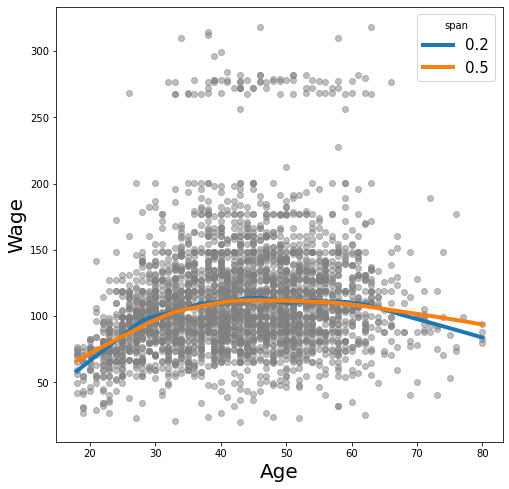

In [33]:
lowess = sm.nonparametric.lowess
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
    fitted = lowess(y,
                    age,
                    frac=span,
                    xvals=age_grid)
    ax.plot(age_grid,
            fitted,
            label='{:.1f}'.format(span),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='span', fontsize=15);